# Standard workflow template - Super-T girder bridge
This example reproduces the grillage model of a super-T bridge from Caprani et al. (2017). In that study, the commercial software LUSAS is used to create the grillage model. Figure 1 shows the Super-T deck cross-section

In [2]:
import numpy as np
import ospgrillage as og
from IPython import display  # to display images in this notebook
%matplotlib inline

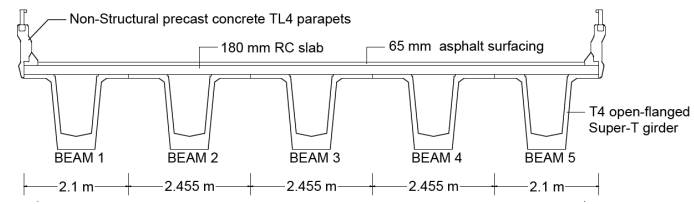

In [ ]:
display.Image("../images/example_cross_section.PNG",width=800)

## Creating the grillage
For this example, the five super-T beams and two edge beams (parapets) of Figure 1 are being modelled similar to Caprani et al. (2017) - with the number of longitudinal and transverse grid lines being 7 and 11 respectively.

In [4]:
# Adopted units: N and m
kilo = 1e3
milli = 1e-3
N = 1
m = 1
mm = milli * m
m2 = m ** 2
m3 = m ** 3
m4 = m ** 4
kN = kilo * N
MPa = N / ((mm) ** 2)
GPa = kilo * MPa

# parameters of bridge grillage
L = 33.5 * m  # span
w = 11.565 * m  # width
n_l = 7  # number of longitudinal members
n_t = 11  # number of transverse members
edge_dist = 1.05 * m  # distance between edge beam and first exterior beam
angle = 0  # skew angle

Create `Material` object of grillage members. Here the same material is defined for all grillage members.

In [5]:
# define material
concrete = og.create_material(material="concrete", code="AS5100-2017", grade="65MPa")

Create `Section` object for each grillage elements. The values of parameters are taken from the LUSAS model used in Colin et al (2017). 

In [6]:
edge_longitudinal_section = og.create_section(
    A=0.934 * m2,
    J=0.1857 * m3,
    Iz=0.3478 * m4,
    Iy=0.213602 * m4,
    Az=0.444795 * m2,
    Ay=0.258704 * m2,
)

longitudinal_section = og.create_section(
    A=1.025 * m2,
    J=0.1878 * m3,
    Iz=0.3694 * m4,
    Iy=0.113887e-3 * m4,
    Az=0.0371929 * m2,
    Ay=0.0371902 * m2,
)

transverse_section = og.create_section(
    A=0.504 * m2,
    J=5.22303e-3 * m3,
    Iy=0.32928 * m4,
    Iz=1.3608e-3 * m4,
    Ay=0.42 * m2,
    Az=0.42 * m2,
)

end_transverse_section = og.create_section(
    A=0.504 / 2 * m2,
    J=2.5012e-3 * m3,
    Iy=0.04116 * m4,
    Iz=0.6804e-3 * m4,
    Ay=0.21 * m2,
    Az=0.21 * m2,
)

Then, create `GrillageMember` objects with the prescribed `Section` and `Material` objects as inputs.

In [7]:
# define grillage members
longitudinal_beam = og.create_member(section=longitudinal_section, material=concrete)
edge_longitudinal_beam = og.create_member(
    section=edge_longitudinal_section, material=concrete
)
transverse_slab = og.create_member(section=transverse_section, material=concrete)
end_transverse_slab = og.create_member(
    section=end_transverse_section, material=concrete
)

In [8]:
# create grillage
simple_grid = og.create_grillage(
    bridge_name="Super-T 33_5m",
    long_dim=L,
    width=w,
    skew=angle,
    num_long_grid=n_l,
    num_trans_grid=n_t,
    edge_beam_dist=edge_dist,
)

No Model_ODB specified, trying to get data from the active model.
3D model


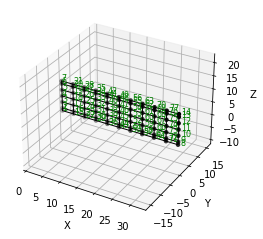

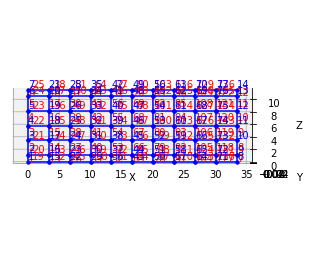

In [9]:
# assign grillage member to element groups of grillage model
simple_grid.set_member(longitudinal_beam, member="interior_main_beam")
simple_grid.set_member(longitudinal_beam, member="exterior_main_beam_1")
simple_grid.set_member(longitudinal_beam, member="exterior_main_beam_2")
simple_grid.set_member(edge_longitudinal_beam, member="edge_beam")
simple_grid.set_member(transverse_slab, member="transverse_slab")
simple_grid.set_member(end_transverse_slab, member="start_edge")
simple_grid.set_member(end_transverse_slab, member="end_edge")

# create the model in OpenSees
simple_grid.create_osp_model(
    pyfile=False
)  # pyfile will not (False) be generated for further analysis (should be create_osp?)
og.opsplt.plot_model(show_nodes="yes",show_nodetags="yes")  # plotting using vfo
og.opsv.plot_model(az_el=(-90, 0))  # plotting using ops_vis
og.plt.show()

Figure 2 shows the model plotted in OpenSees model space.

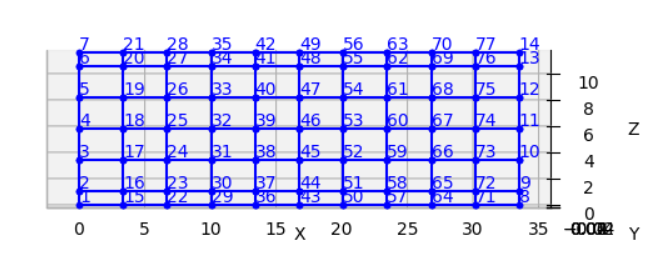

In [10]:
display.Image("../images/33m_bridge.PNG",width=800)

## Adding load cases to model
Here we create and add load cases to the simple_grid model for analysis.

The first load case is a simple line load running along mid span width, to check that the model is behaving appropriately.

In [11]:
# reference unit load for various load types
P = 1 * kN
# name strings of load cases to be created
static_cases_names = [
    "Line Test Case",
    "Points Test Case (Global)",
    "Points Test Case (Local in Point)",
    "Patch Test Case",
]

# Line load running along midspan width (P is kN/m)
# Create vertical load points in global coordinate system
line_point_1 = og.create_load_vertex(x=L / 2, z=0, p=P)
line_point_2 = og.create_load_vertex(x=L / 2, z=w, p=P)
test_line_load = og.create_load(
    name="Test Load", point1=line_point_1, point2=line_point_2
)

# Create load case, add loads, and assign
line_case = og.create_load_case(name=static_cases_names[0])
line_case.add_load(test_line_load)

simple_grid.add_load_case(line_case)

The second load case is comprised of several point loads, added into a single Compound Load type, so they can be manipulated as a group.

In [12]:
# Compound point loads along midspan width (P is kN)
# working in global coordinate system
p_list = [
    0,
    edge_dist,
    edge_dist + 2 * m,
    edge_dist + 4 * m,
    edge_dist + 6 * m,
    w - edge_dist,
    w,
]  # creating list of load position

test_points_load = og.create_compound_load(name="Points Test Case (Global)")

# create point load in global coordinate
for p in p_list:
    point = og.create_load(
        name="Point", point1=og.create_load_vertex(x=L / 2, z=p, p=P)
    )
    # add to compound load
    test_points_load.add_load(load_obj=point)

# Create load case, add loads, and assign
points_case = og.create_load_case(name=static_cases_names[1])
points_case.add_load(test_points_load)

simple_grid.add_load_case(points_case)

The third load case is identical to the second load case with Compounded point loads, but this time defining Compound loads in Local coordinates then mapping the local coordinate system of the compound load to the global coordinates of the grillage model.

In [13]:
# Compound point loads along midspan width
# working in user-defined local coordinate (in point load)
test_points_load = og.create_compound_load(name="Points Test Case (Local in Point)")

# create point load in local coordinate space
for p in p_list:
    point = og.create_load(
        name="Point", point1=og.create_load_vertex(x=0, z=p, p=P)
    )
    # add to compound load
    test_points_load.add_load(load_obj=point)

# shift from local to global
test_points_load.set_global_coord(og.Point(L / 2, 0, 0))

# Create load case, add loads, and assign
points_case = og.create_load_case(name=static_cases_names[2])
points_case.add_load(test_points_load)

simple_grid.add_load_case(points_case)

The fourth load case entails a patch load over the entire deck surface:



In [14]:
# Patch load over entire bridge deck (P is kN/m2)
patch_point_1 = og.create_load_vertex(x=0, z=0, p=P)
patch_point_2 = og.create_load_vertex(x=L, z=0, p=P)
patch_point_3 = og.create_load_vertex(x=L, z=w, p=P)
patch_point_4 = og.create_load_vertex(x=0, z=w, p=P)
test_patch_load = og.create_load(
    loadtype="patch",
    name="Test Load",
    point1=patch_point_1,
    point2=patch_point_2,
    point3=patch_point_3,
    point4=patch_point_4,
)

# Create load case, add loads, and assign
patch_case = og.create_load_case(name=static_cases_names[3])
patch_case.add_load(test_patch_load)
simple_grid.add_load_case(patch_case)

## Adding a moving load analysis
For bridge loading, it is imperative to model loads that move, and to consider the static analysis of the bridge deck under each position of the moving load. Here’s how we create and add a moving load (e.g. a truck) to the 28 m bridge model.

In [15]:
# 2 axle truck (equal loads, 2x2 spacing centre line running)
axl_w = 2 * m  # axle width
axl_s = 2 * m  # axle spacing
veh_l = axl_s  # vehicle length
# create truck in local coordinate system
two_axle_truck = og.create_compound_load(name="Two Axle Truck")
# note here we show that we can directly interact and create load vertex using LoadPoint namedtuple instead of create_load_vertex()
point1 = og.create_load(
    name="Point", point1=og.LoadPoint(x=0, y=0, z=0, p=P)
)
point2 = og.create_load(
    name="Point", point1=og.LoadPoint(x=0, y=0, z=axl_w, p=P)
)
point3 = og.create_load(
    name="Point", point1=og.LoadPoint(x=axl_s, y=0, z=axl_w, p=P)
)
point4 = og.create_load(
    name="Point", point1=og.LoadPoint(x=axl_s, y=0, z=0, p=P)
)

two_axle_truck.add_load(load_obj=point1)
two_axle_truck.add_load(load_obj=point2)
two_axle_truck.add_load(load_obj=point3)
two_axle_truck.add_load(load_obj=point4)

# create path object in global coordinate system - centre line running of entire span
# when local coord: the path describes where the moving load *origin* is to start and end
single_path = og.create_moving_path(
    start_point=og.Point(0 - axl_w, 0, w / 2 - axl_w / 2),
    end_point=og.Point(L, 0, w / 2 - axl_w / 2),
    increments=int(np.round(L) + veh_l + 1),
)

# create moving load (and case)
moving_truck = og.create_moving_load(name="Moving Two Axle Truck")

# Set path to all loads defined within moving_truck
moving_truck.set_path(single_path)
# note: it is possible to set different paths for different compound loads in one moving load object
moving_truck.add_load(two_axle_truck)

# Assign
simple_grid.add_load_case(moving_truck)

## Analysis
Next, analyze all load cases added to the model:

In [16]:
simple_grid.analyze()

## Getting load case results
Finally, get the xarray DataSet of the results:

In [17]:
results = simple_grid.get_results() # gets basic results



For information on the returned object from :func:`~ospgrillage.osp_grillage.OspGrillage.get_results`,see :ref:`PostProcessing`.

## Getting load combination results
With the results of the basic load cases now known, we can calculate factored combinations of these load cases that are of interest:

In [18]:
l_factor = 2.3
p_factor = 0.5
# combination with line load case and patch load case
load_combinations = {static_cases_names[0]:l_factor,static_cases_names[-1]:p_factor}
combination_results = simple_grid.get_results(combinations=load_combinations)

## Data processing
Having the results be in xarray DataSet, we can do many things with it such as slicing and query its data.

The following example shows how to extract bending moments at midspan - the critical location for the defined load cases.

First for static load cases, we extract bending moments about the global -axis for each i node of grillage member (since i node correspond to the nodes in the mid span).

In [19]:
# get list of longitudinal element tags along/near mid_span i.e. 84 to 90 in Figure 1
ele_set = list(range(84, 90 + 1))
# query
extracted_bending = results.forces.sel(Loadcase=static_cases_names, Element=ele_set, Component="Mz_i")

The extracted_bending variable holds the load case for ‘Line Test Case’, ‘Point Test Case(Global)’, ‘Points Test Case (Local in Point)’, ‘Points Test Case (Local in Compound)’, ‘Patch Test Case’.

Should we sum the nodal forces from members on one side, we expect it to approximately equal PL/4:

In [20]:
np.sum(
np.array(
    results.forces.sel(
        Loadcase=static_cases_names, Element=ele_set, Component="Mz_i"
    )
),
axis=1,
)

array([  96856.875     ,   58625.        ,   58625.        ,
       1634136.28124999])

### Process load combinations results
Here we sum the nodal forces from the mid span - i node

In [21]:
sum_node_force = np.sum(
    np.array(combination_results.forces.sel(Element=ele_set, Component="Mz_i"))
)

### Extract and process moving load results
Here we are accessing and querying data of the moving load case.

In [22]:
move_results = simple_grid.get_results(load_case="Moving Two Axle Truck")

One can query results at specific position of the moving load by looking up the index of load case.

In the following example we query the bending moment about -axis component, with the load case corresponding to where the load groups are at/near midspan L = 16.75 m, and the longitudinal elements along/near mid-span, i.e. element 84 to 90 in Figure 1:

In [23]:
# selecting load case of specific load position
integer = int(
    L / 2 - 1 + 2
)  # here we choose when the load groups are at/near mid span L = 14m i.e. 17

# query
mid_span_bending = move_results.forces.isel(Loadcase=integer).sel(
    Element=ele_set, Component="Mz_i"
)

Finally, summing the query of bending moment and comparing with theoretical calculation:



In [24]:
bending_z = np.sum(np.array(mid_span_bending))

# Hand calc:
bending_z_theoretical = 2 * P * (L / 2 - axl_s / 2)  # 31500

print("bending_z ={}".format(bending_z))
print("bending_z_theoretical ={}".format(bending_z_theoretical))

bending_z =31499.99999999989
bending_z_theoretical =31500.0


The following is printed to terminal (units in N m) :



In [25]:
bending_z = 31499.999999999913
bending_z_theoretical = 31500.0

and these are a good match.